# Building a basic classifier with SCoPe


# Overview 

### Problem description

The light curves contain important information about the nature of the objects, which is a key tool in astrophysics and many other fields. However, as ZTF, LSST, and other large surveys come online, billions of data samples need to be analyzed. Therefore, developing intelligent automatic algorithms is needed to complement the inefficient and expensive human labor. 

![image info](./diagrams/Interface.png)

In this project, we want to take advantage of machine learning or deep learning methods to achieve the efficient classifier.

<img src="./diagrams/MLDL.png" width="500">


### Difficulties

The main difficulty is how to take advantage of the domain knowledge, i.e., building a model which can classify hierarchically. The following images are the conceptual hierarchical classification relationship used in SCoPe.

<img src="./diagrams/Phenomological.jpg" width="800">


<img src="./diagrams/Ontological.jpg" width="1000">


### The problem

* Preprocess the dataset and analyze the ***importance of features***. ***Visualization technology*** helps us to better understand the meaning of different features.

* Regarding it as the multi-task classification with each task is an either binary- or multi-classes classification problem, we adopt some ***machine learning models***, including SVM, decision tree, random forest, AdaBoost, XGBoost. Furthermore, we will look into a ***hierarchical schema*** to take advantage of the domain knowledge. 

* (For Homework 5): Use an ***end-to-end neural network***, which adopts CNN and auto-encoder modules to compress the features. In the down stream part, different classifiers are used for different tasks. Those components are trained jointly, and we also design a loss function, which can implicitly learn the hierarchical relationship. We will finish when our model can achieve high accuracy.

### Building off work in two published papers: 

* The ZTF Source Classification Project: I. Methods and Infrastructure
  * https://arxiv.org/abs/2102.11304 and 
* The ZTF Source Classification Project: II. Periodicity and variability processing metrics
  * https://arxiv.org/abs/2009.14071 


# Light Curve Classification

## Dataset-driven Approach

* The classification labels are not mutually exclusive
  * They follow a classification hierarchy
  * A single sample can have multiple valid labels
  
  
### There are two sets of label hierarchies: 
**phenomenological** = how it appears; observed characteristics \
**ontological** = what it is classified as in Astronomical terminology 

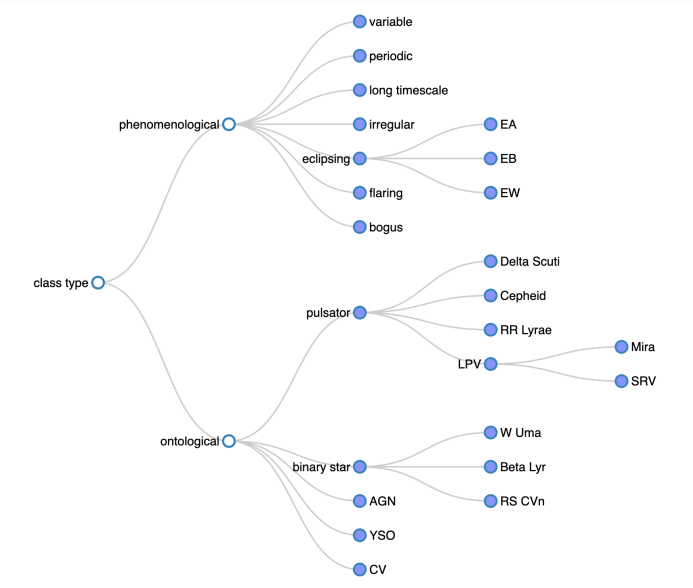

## Top-down approach: 

Our approach to this problem is top-down, separating out the classes as you walk down the hierarchy tree.

### Phase 1: Start on the upper levels of the Hierarchy:
* Bogus vs Real
  * Samples classified Real -> variable non variable
    * Samples classified variable --> feed into both ontological and phenomenological trees

    * (ontological is by definition variable)

### Phase 2: Split out into Ontological and Phenomenological trees 
#### Ontological side
* pulsators
  * first classifier pulsator vs non-pulsator
  * second classifier to separate out pulsators
* binary stars
  * first classifier binary star vs non-binary star
  * second classifier to separate out binary stars

#### Phenomenological side
* variable vs non variable
* periodic vs nonperiodic
* periodic types
*  EA / EB / EW if possible

### Import Packages

In [1]:
# Import Packages
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from IPython.display import display
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn import svm

from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from IPython.display import display, Image

warnings.filterwarnings("ignore")

### Import Data

We first load the data from the dataset file and save it in ```df_raw_data```. Then, we extract the features/labels used in the paper and save them in ```df_feats``` and ```df_labels``` respectively.

In [2]:
DATA_PATH = '../../scope/data/dataset.csv'
df_raw_data = pd.read_csv(DATA_PATH)

In [3]:
LABELS_COL = [# 10 Cols for the phenomenological classifiers 
              'variable', 'periodic', 'long timescale', 'irregular', 'eclipsing', 'EA', 'EB', 'EW', 'flaring', 'bogus',
              # new
              'non-variable', 'dipping', 'blend', 'bright star', 'ccd artifact', 'galaxy', 'sinusoidal', 'sawtooth', 
              'elliptical',
    
    
              # 13 Cols for the ontological classifiers
              'pulsator', 'Delta Scu', 'Cepheid', 'RR Lyrae', 'LPV', 'Mira', 'SRV', 'binary star', 'W Uma', 'Beta Lyr',
              'RS CVn', 'AGN', 'YSO',
              # new
              'F', 'O', 'Cepheid type-II', 'detached eclipsing MS-MS', 'compact binary', 'eclipsing WD+dM (NN Ser)',
              'eclipsing sdB+dM (HW Vir)', 'RR Lyrae Blazhko', 'RR Lyrae ab', 'RR Lyrae c', 'RR Lyrae d', 'BL Her', 
              'RV Tau', 'W Virginis',  
    
              # unclear:
              'double period', 'half period', 'multi periodic', 'nice', 'niice', 'wrong period',
             ]

FEATS_COL = [# 38 Cols for the phenomenological classifiers 
             'period', 'significance', 'n', 'median', 'wmean', 'wstd', 'chi2red', 'roms', 'norm_peak_to_peak_amp',
             'norm_excess_var', 'median_abs_dev', 'iqr', 'f60', 'f70', 'f80' , 'f90', 'skew', 'smallkurt', 
             'inv_vonneumannratio', 'welch_i', 'stetson_j', 'stetson_k', 'ad', 'sw', 'f1_power', 'f1_bic','f1_amp', 
             'f1_phi0', 'f1_relamp1', 'f1_relphi1', 'f1_relamp2', 'f1_relphi2', 'f1_relamp3', 'f1_relphi3', 'f1_relamp4', 
             'f1_relphi5', 'n_ztf_alerts', 'mean_ztf_alert_braai',  
             
             # 30 Cols for the ontological classifiers
             'AllWISE__w1mpro', 'AllWISE__w1sigmpro', 'AllWISE__w2mpro', 'AllWISE__w2sigmpro', 'AllWISE__w3mpro',
             'AllWISE__w3sigmpro', 'AllWISE__w4mpro','AllWISE__w4sigmpro', 'AllWISE__ph_qual',
             'Gaia_DR2__phot_g_mean_mag', 'Gaia_DR2__phot_bp_mean_mag', 'Gaia_DR2__phot_rp_mean_mag', 'Gaia_DR2__parallax',
             'Gaia_DR2__parallax_error', 'Gaia_DR2__pmra', 'Gaia_DR2__pmra_error', 'Gaia_DR2__pmdec', 'Gaia_DR2__pmdec_error',
             'Gaia_DR2__astrometric_excess_noise', 'Gaia_DR2__phot_bp_rp_excess_factor',
             'PS1_DR1__gMeanPSFMag', 'PS1_DR1__gMeanPSFMagErr', 'PS1_DR1__rMeanPSFMag', 'PS1_DR1__rMeanPSFMagErr', 
             'PS1_DR1__iMeanPSFMag', 'PS1_DR1__iMeanPSFMagErr', 'PS1_DR1__zMeanPSFMag', 'PS1_DR1__zMeanPSFMagErr', 
             'PS1_DR1__yMeanPSFMag', 'PS1_DR1__yMeanPSFMagErr', 'PS1_DR1__qualityFlag']


df_feats = df_raw_data[FEATS_COL]
df_labels = df_raw_data[LABELS_COL]

In [4]:
df_feats

,period,significance,n,median,wmean,wstd,chi2red,roms,norm_peak_to_peak_amp,norm_excess_var,...,PS1_DR1__gMeanPSFMagErr,PS1_DR1__rMeanPSFMag,PS1_DR1__rMeanPSFMagErr,PS1_DR1__iMeanPSFMag,PS1_DR1__iMeanPSFMagErr,PS1_DR1__zMeanPSFMag,PS1_DR1__zMeanPSFMagErr,PS1_DR1__yMeanPSFMag,PS1_DR1__yMeanPSFMagErr,PS1_DR1__qualityFlag
0,638.203392,10.323892,263.0,17.2810,17.280580,0.026293,1.302158,0.834601,0.005928,5.959733e-07,...,0.008173,16.746901,0.002109,16.545099,0.002660,16.490801,0.003791,16.441299,0.009441,60.0
1,0.024785,13.238870,64.0,20.7980,20.784238,0.213611,1.750986,1.103918,0.013147,4.627087e-05,...,0.000000,20.716000,0.070433,19.948601,0.027574,19.569901,0.025853,19.288401,0.018201,52.0
2,0.143803,42.274978,52.0,20.0900,20.086235,0.216376,4.482082,1.628610,0.019138,1.371048e-04,...,0.216329,20.288799,0.021331,19.140900,0.027460,18.440201,0.021492,17.916401,0.016800,60.0
3,0.413181,125.629450,68.0,18.1750,18.132819,0.133568,13.397498,3.236169,0.012696,5.158521e-05,...,0.026070,18.137800,0.025632,18.086201,0.008809,18.142000,0.014741,18.162600,0.029057,52.0
4,0.408992,48.261472,80.0,15.5615,15.564013,0.038485,6.665935,2.147679,0.004172,5.185334e-06,...,0.010956,15.573000,0.002684,15.526600,0.011109,15.457800,0.010758,15.440800,0.003390,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.147927,446.147022,142.0,17.8795,17.902267,0.151464,32.885707,4.779705,0.016361,8.421307e-05,...,0.036146,17.875099,0.015237,17.474800,0.005624,17.372900,0.021434,17.202000,0.005745,60.0
69996,0.142266,350.176987,68.0,16.0745,16.120440,0.144459,139.722523,10.116485,0.013583,8.378785e-05,...,0.052543,16.104900,0.027450,15.940100,0.016539,15.735300,0.008238,15.792400,0.037322,60.0
69997,0.057444,48.505500,55.0,17.5680,17.547884,0.074043,10.050414,2.742242,0.007125,1.586307e-05,...,0.020108,17.561300,0.019155,17.592699,0.008392,17.648199,0.010982,17.542500,0.020736,60.0
69998,0.051981,55.382964,55.0,18.2570,18.232474,0.121420,9.432388,2.677773,0.010803,4.006329e-05,...,0.029872,18.257601,0.022021,18.247400,0.021117,18.378099,0.008947,18.277901,0.022746,52.0


In [5]:
df_labels

,variable,periodic,long timescale,irregular,eclipsing,EA,EB,EW,flaring,bogus,...,RR Lyrae d,BL Her,RV Tau,W Virginis,double period,half period,multi periodic,nice,niice,wrong period
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Pre-process 

* Encode some labels and features:
  (1) String => Int
  (2) Continuous => Discrete
  
* Normalize (rescale) the features

* Random split for training / test sets

In [6]:
# Encode the labels
df_labels = df_labels.apply(LabelEncoder().fit_transform)

# Special case: Convert string to float
df_feats['AllWISE__ph_qual'] = LabelEncoder().fit_transform(df_feats['AllWISE__ph_qual'])

# Normalization
df_feats_values = df_feats.values
df_feats_values_scaled = StandardScaler().fit_transform(df_feats_values)
df_feats_scaled = pd.DataFrame(df_feats_values_scaled, columns=df_feats.columns)
df_feats_scaled

,period,significance,n,median,wmean,wstd,chi2red,roms,norm_peak_to_peak_amp,norm_excess_var,...,PS1_DR1__gMeanPSFMagErr,PS1_DR1__rMeanPSFMag,PS1_DR1__rMeanPSFMagErr,PS1_DR1__iMeanPSFMag,PS1_DR1__iMeanPSFMagErr,PS1_DR1__zMeanPSFMag,PS1_DR1__zMeanPSFMagErr,PS1_DR1__yMeanPSFMag,PS1_DR1__yMeanPSFMagErr,PS1_DR1__qualityFlag
0,1.795541,-0.411116,1.056842,-0.080996,-0.070772,-0.729371,-0.204919,-0.618402,-0.556206,-0.090013,...,-0.505132,-0.171156,-0.711477,-0.108664,-0.679382,-0.035408,-0.589965,0.087552,-0.428986,0.202861
1,-0.169144,-0.404608,-0.609176,1.717669,1.745705,0.605940,-0.203427,-0.567115,-0.058580,-0.067296,...,-0.771984,1.529579,2.328723,1.432994,0.796992,1.331472,0.413797,1.111349,-0.121882,-0.577069
2,-0.168778,-0.339781,-0.709640,1.355583,1.383824,0.625651,-0.194344,-0.467194,0.354400,-0.022121,...,6.291251,1.346526,0.143841,1.067136,0.790237,0.829973,0.215383,0.617988,-0.170997,0.202861
3,-0.167949,-0.153682,-0.575688,0.376213,0.371072,0.035347,-0.164693,-0.161056,-0.089659,-0.064653,...,0.079213,0.424836,0.335221,0.589397,-0.315000,0.697595,-0.091769,0.706519,0.258703,-0.577069
4,-0.167962,-0.326416,-0.475225,-0.960383,-0.960730,-0.642459,-0.187080,-0.368344,-0.677252,-0.087730,...,-0.414266,-0.674166,-0.685891,-0.570005,-0.178704,-0.493979,-0.272985,-0.272220,-0.641119,0.202861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,-0.168765,0.561914,0.043836,0.225089,0.251542,0.162925,-0.099879,0.132890,0.162960,-0.048426,...,0.408199,0.312270,-0.127323,0.312456,-0.503739,0.356175,0.212744,0.361095,-0.558559,0.202861
69996,-0.168783,0.347649,-0.575688,-0.698025,-0.672249,0.112984,0.255438,1.149209,-0.028490,-0.048638,...,0.943568,-0.446250,0.416117,-0.382705,0.143071,-0.370791,-0.387639,-0.145787,0.548454,0.202861
69997,-0.169044,-0.325871,-0.684524,0.065781,0.067812,-0.388981,-0.175824,-0.255117,-0.473654,-0.082420,...,-0.115449,0.177809,0.047016,0.365860,-0.339711,0.478386,-0.262794,0.483536,-0.033011,0.202861
69998,-0.169061,-0.310516,-0.684524,0.418150,0.422739,-0.051247,-0.177880,-0.267395,-0.220118,-0.070384,...,0.203350,0.476170,0.174543,0.662414,0.414358,0.802405,-0.355381,0.747981,0.037455,-0.577069


In [7]:
# Train / test split
# YOUR CODE HERE
rs=8581
#X_train, X_test, y_train, y_test = train_test_split(...

# Data Visualizations 

Below, we visualize the categories for each variable. We can see that many of these variables have imbalanced classes, meaning we have significantly more data points classified as one variable compared to another. This will become relevant as we analyze the results from our models later.

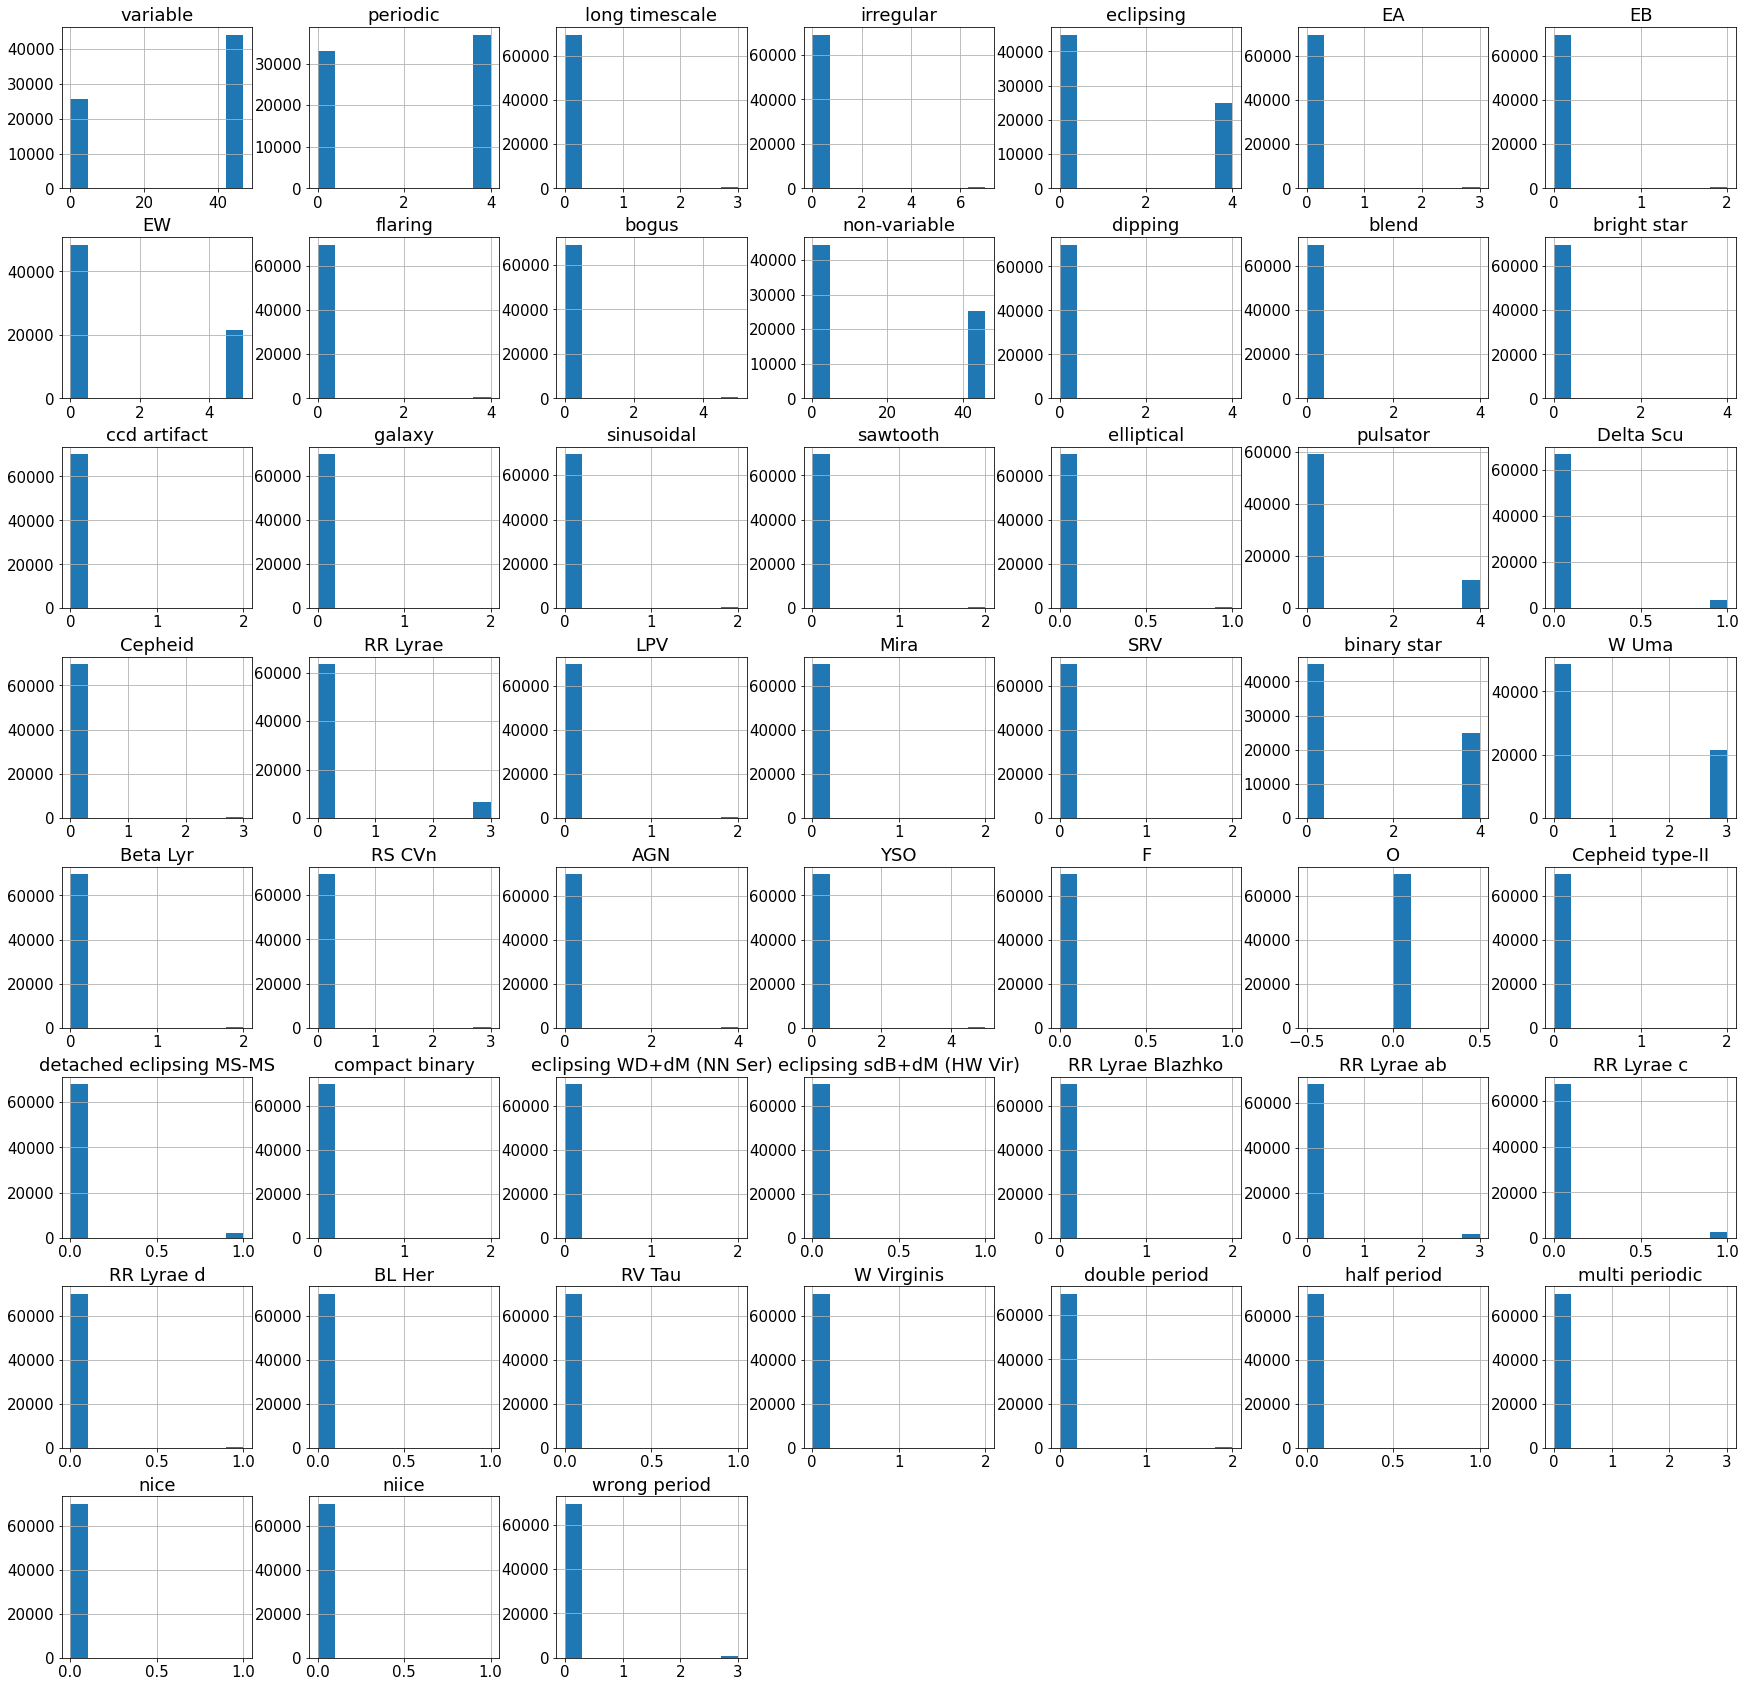

In [10]:
# class imbalance 
df_labels.hist(figsize=(30,30))
plt.show()

Below, we visualize the correlation among the labels to see if correlation between variables may be due to the hierarchical nature of the labels.

Note that some of the hierarchical structure does play a role in the correlation between variables. For example, eclipsing Lightcurves can be subcategorized as EA, EB, or EW. We can see that there is a large correlation (near 1) between the eclipsing and EW variables as well as small correlations (between 0.25-0.5) between the eclipsing & EA and eclipsing & EB variables. It is also worth noting that EW has the most balanced classes out of those three subcategories (which can be seen below), which may be why it is more correlated with the eclipsing variable.

Another example is RR Lyrae, because the four subcategories of RR Lyrae (RR Lyrae Blazhko, RR Lyrae ab, RR Lyrae c, and RR Lyrae d) all have positive correlations with the RR Lyrae variable between 0.25-0.75.

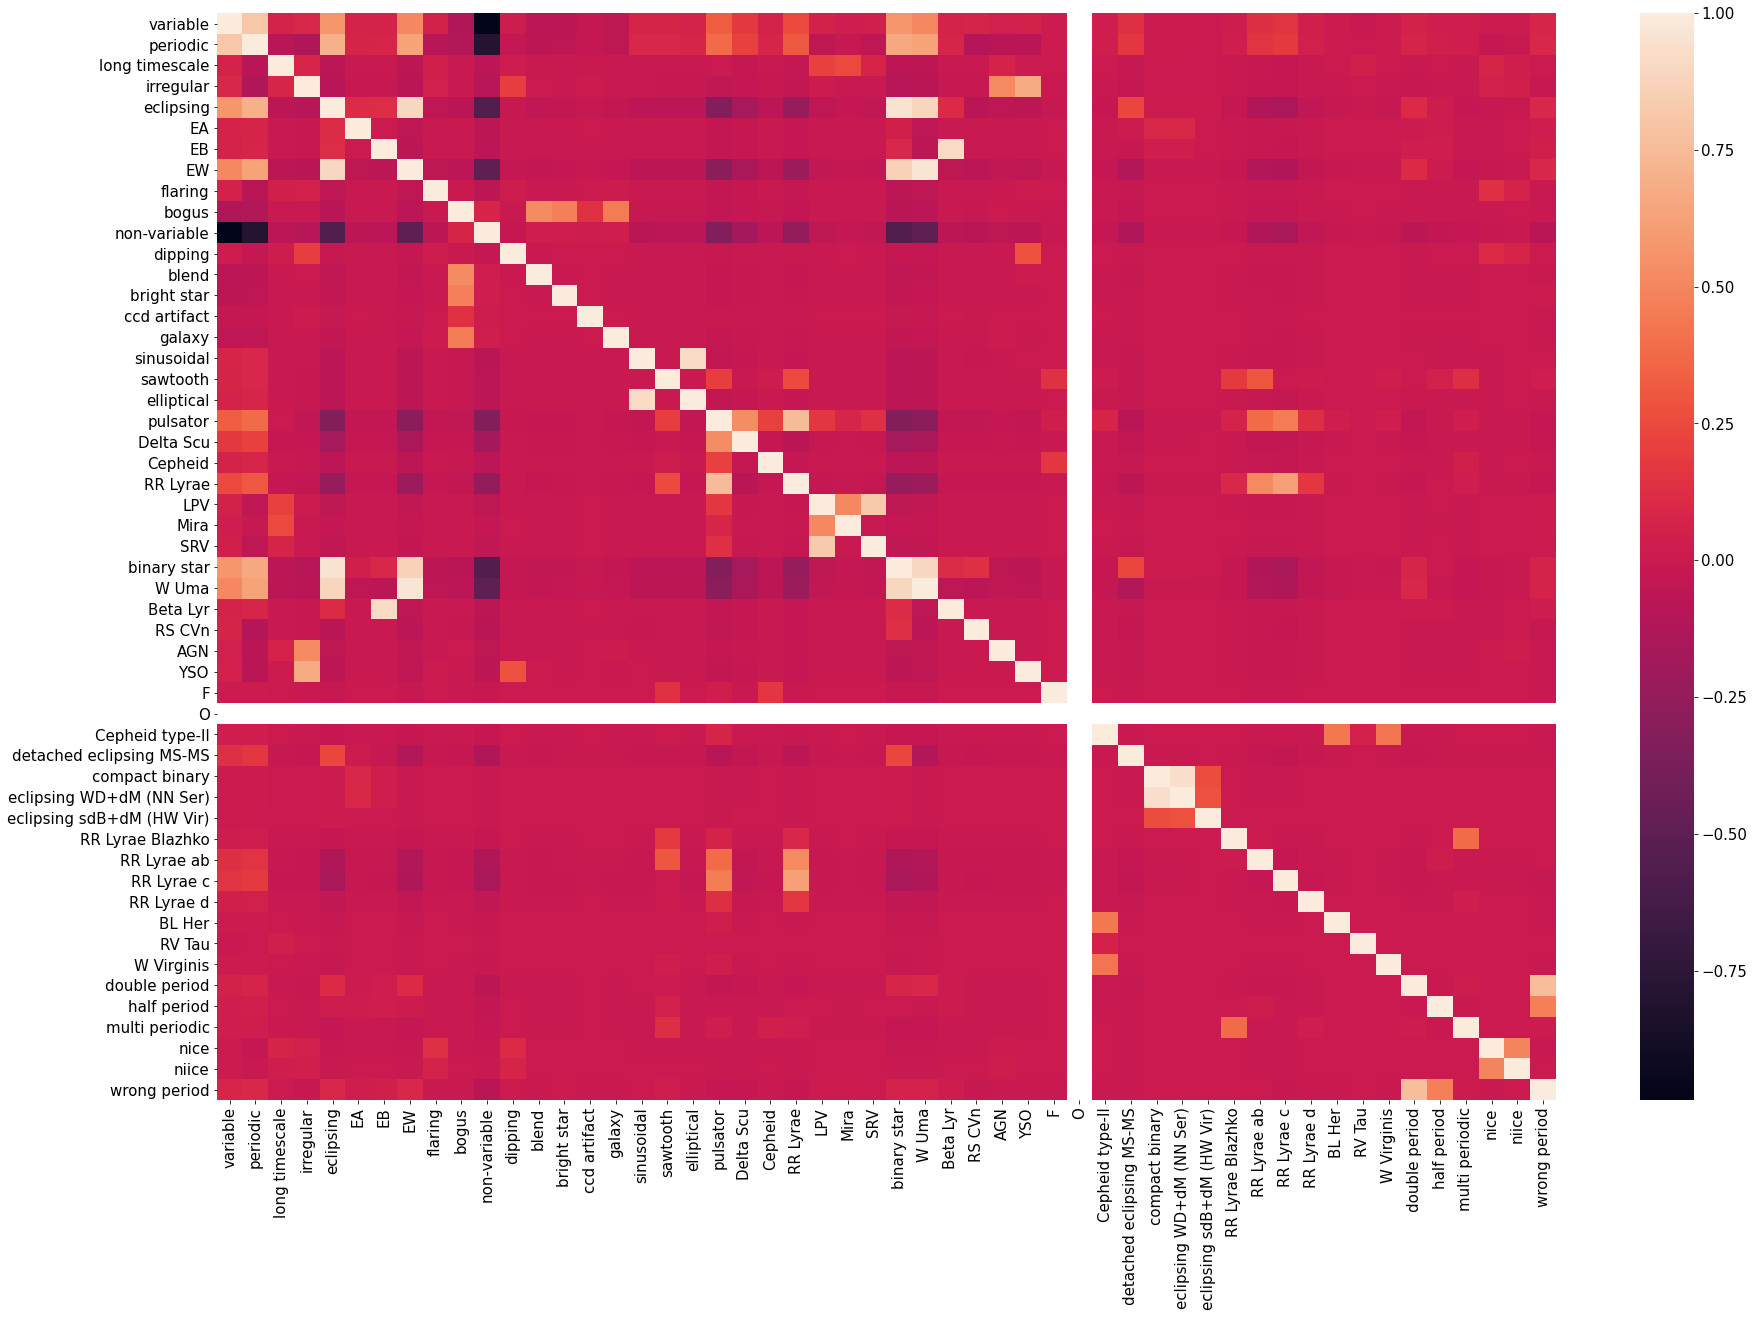

In [9]:
# talk about correlation matrix with relation to structure

plt.figure(figsize=(30,20))
plt.rcParams.update({'font.size': 15})

corrMatrix = df_labels.corr()
sns.heatmap(corrMatrix)
plt.show()

# Feature Selection 

Feature selection is a process of analyzing and choosing the features that contribute the most to predicting the labels correctly. As there are so many features in the dataset, by performing feature selection, we expect to improve the performance of our models. 

Common Approaches of feature selection are univariate selection, feature importance and analyzing a correlation matrix. Due to the large size of our dataset, we will use univariate selection. 

Univariate Selection uses statistical tests to select features that have the strongest relationships with the output variable.  **SelectKBest** is included in the scikit-learn library which we will use below. We chose to use the default scoring function of 'f_classif' which is the ANOVA F-value between label and feature for classification tasks.

Below is an example for a single label (variable), finding the top 15 features related to this label. After that, I will loop through each of the labels in the dataset to obtain the top 15 features for each label. 

In [12]:
X = df_feats_scaled
y = df_labels['variable']

#apply SelectKBest class to extract top 15 best features
# YOUR CODE HERE
# bestfeatures = SelectKBest(...
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(15,'Score') #print 15 best features

,Specs,Score
37,mean_ztf_alert_braai,2769.927797
24,f1_power,2386.816609
7,roms,351.543199
4,wmean,293.264302
3,median,285.258159
36,n_ztf_alerts,280.151037
21,stetson_k,253.233712
29,f1_relphi1,234.159212
1,significance,163.863026
60,PS1_DR1__rMeanPSFMag,138.241915


In [13]:
cols = df_labels.columns
top25_ALL = []

for c in cols:
    #print("Top features with respect to label ", c)
    y = df_labels[c]
    # YOUR CODE HERE
    bestfeatures = SelectKBest(...
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    top25_ALL = np.concatenate((top25_ALL, featureScores.nlargest(25,'Score')["Specs"].values))

In [14]:
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

In [15]:
cols2 = ['feature', 'count']
lst = []

for c in X.columns:
    lst.append([c, countX(top25_ALL, c)])
    
count_df = pd.DataFrame(lst, columns=cols2)    

# sort dataframe and choose the top 25
count_df = count_df.sort_values(by = 'count', ascending=False)
top25_feats = count_df.head(n=25)['feature'].values

count_df.head(n=25)

,feature,count
37,mean_ztf_alert_braai,43
12,f60,41
11,iqr,40
8,norm_peak_to_peak_amp,40
13,f70,39
10,median_abs_dev,38
24,f1_power,37
14,f80,37
15,f90,36
7,roms,34


Now you can use the count of labels to understand feature importance

In [1]:
# YOUR CODE HERE

### Conclusions of feature importance
Comment on the features below

Since there are so many differing labels in the dataset, the group of features that had the strongest relationships with each labels vary widely.

# Machine Learning 

Split the features into training and testing sets

In [17]:
naive_df_feats_scaled = df_feats_scaled
# YOUR CODE HERE
X_train2, X_test2, y_train2, y_test2 = train_test_split(...

### Modeling

#### Basic Models:
- Decision Tree (utilizing MultiOutputClassifier) 
- Random Forest (utilizing MultiOutputClassifier)
- AdaBoost (utilizing MultiOutputClassifier)
- XGBoost (utilizing MultiOutputClassifier)
- Support Vector Machines (RBF, linear, and polynomial kernels)

#### Hierarchical Model:
- Hierarchical Support Vector Machines (RBF kernel)

In [18]:
def get_accuracy(y_true, y_pred):
    acc_list=[]

    for i in range(y_true.shape[1]):
        acc_list.append(accuracy_score(y_true[:, i], y_pred[:, i]))

    return np.array(acc_list)

### Decision Tree Classifier

In [19]:
print(y_train2)

# Model
DT = MultiOutputClassifier(DecisionTreeClassifier(), n_jobs=-1).fit(X_train2, y_train2)
# Prediction
DT_y_pred = DT.predict(X_test2)
# Evaluation
DT_acc = get_accuracy(y_test2, DT_y_pred) 
display(pd.DataFrame(DT_acc.reshape(1,-1), columns=df_labels.columns))
print("The mean accuracy: ", np.mean(DT_acc))

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [47  4  0 ...  0  0  0]
 ...
 [47  4  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [47  4  0 ...  0  0  0]]


,variable,periodic,long timescale,irregular,eclipsing,EA,EB,EW,flaring,bogus,...,RR Lyrae d,BL Her,RV Tau,W Virginis,double period,half period,multi periodic,nice,niice,wrong period
0,0.954629,0.938257,0.993486,0.988571,0.938086,0.990743,0.989,0.9356,0.997514,0.988086,...,0.996543,0.9998,0.999971,0.999886,0.990314,0.996514,0.9976,0.999657,0.999943,0.984429


The mean accuracy:  0.9864065934065935


### Random Forest Classifier

In [20]:
# YOUR CODE HERE
# RF = MultiOutputClassifier(...
RF_y_pred = RF.predict(X_test2)
RF_acc = get_accuracy(y_test2, RF_y_pred)
display(pd.DataFrame(RF_acc.reshape(1,-1), columns=df_labels.columns))
print("The mean accuracy: ", np.mean(RF_acc))

,variable,periodic,long timescale,irregular,eclipsing,EA,EB,EW,flaring,bogus,...,RR Lyrae d,BL Her,RV Tau,W Virginis,double period,half period,multi periodic,nice,niice,wrong period
0,0.975686,0.963943,0.995543,0.993371,0.961457,0.994771,0.993657,0.959514,0.998371,0.993886,...,0.997714,0.9998,0.999971,0.999857,0.995857,0.998486,0.998714,0.9998,1.0,0.992857


The mean accuracy:  0.9918835164835164


### AdaBoost Classifier

In [21]:
# YOUR CODE HERE
# AdaBoost = MultiOutputClassifier(...
AdaBoost_y_pred = AdaBoost.predict(X_test2)
AdaBoost_acc = get_accuracy(y_test2, AdaBoost_y_pred)
display(pd.DataFrame(AdaBoost_acc.reshape(1,-1), columns=df_labels.columns))
print("The mean accuracy: ", np.mean(AdaBoost_acc))

,variable,periodic,long timescale,irregular,eclipsing,EA,EB,EW,flaring,bogus,...,RR Lyrae d,BL Her,RV Tau,W Virginis,double period,half period,multi periodic,nice,niice,wrong period
0,0.922857,0.889171,0.930057,0.986114,0.8556,0.349286,0.211286,0.808286,0.994657,0.913886,...,0.9972,0.9998,0.999971,0.999857,0.994571,0.9974,0.983886,0.9998,1.0,0.871971


The mean accuracy:  0.8876708791208792


### XGBoost Classifier

In [51]:
# YOUR CODE HERE
# XGBoost = MultiOutputClassifier(...
XGBoost_y_pred = XGBoost.predict(X_test2)
XGBoost_acc = get_accuracy(y_test2, XGBoost_y_pred)
display(pd.DataFrame(XGBoost_acc.reshape(1,-1), columns=df_labels.columns))
print("The mean accuracy: ", np.mean(XGBoost_acc))

,variable,periodic,long timescale,irregular,eclipsing,EA,EB,EW,flaring,bogus,...,RR Lyrae d,BL Her,RV Tau,W Virginis,double period,half period,multi periodic,nice,niice,wrong period
0,0.970831,0.963611,0.996238,0.993768,0.961475,0.995027,0.994214,0.956008,0.99831,0.992572,...,0.998135,0.999713,1.0,0.999777,0.994421,0.998135,0.998757,0.999793,0.999936,0.990628


The mean accuracy:  0.9916738597880808


### Support Vector Machines (SVM)

Can try out different kernels, below, will try RBF (Radial Basis Function) Kernel (other options include Linear Kernel and Polynomial Kernel)

In [ ]:
#RBF Kernel

svm_rbf_prediction_accuracies = []
svm_rbf_prediction_train_accuracies = []

for i in range(y_train2.shape[1]):
    # YOUR CODE HERE
    # clf = svm.SVC(...
    # clf.fit(...
    pred_train = clf.predict(X_train2)
    acc_train = accuracy_score(y_train2[:,i], pred_train)
    svm_rbf_prediction_train_accuracies.append(acc_train)
    pred = clf.predict(X_test2)
    acc = accuracy_score(y_test2[:,i], pred)
    svm_rbf_prediction_accuracies.append(acc)
#         print(LABELS_COL[i], ': ', acc)

print('Train Set Mean Accuracy: ', np.mean(svm_rbf_prediction_train_accuracies))
print('Test Set Mean Accuracy: ', np.mean(svm_rbf_prediction_accuracies))

In [ ]:
plt.figure(figsize=(30,7))
plt.rcParams.update({'font.size': 22})

barWidth = 0.4

r1 = np.arange(len(svm_rbf_prediction_accuracies))
r2 = [x + barWidth for x in r1]

plt.bar(r1,svm_rbf_prediction_train_accuracies, width=barWidth, edgecolor='black', label='Train Set')
plt.bar(r2,svm_rbf_prediction_accuracies, color='pink', width=barWidth, edgecolor='black', label='Test Set')

plt.xlabel('Label')
plt.xticks([r + barWidth for r in range(len(svm_rbf_prediction_accuracies))], labels, rotation=90)
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

We see a pattern here.  The labels with more balanced classes, such as EW, have smaller accuracies, while the labels with more imbalanced classes have higher accuracies.  This indicates that the SVM may be overfitting to the labels with imbalanced classes due to a lack of data in one of the classes.  A confusion matrix would likely indicate that the SVM predicts the data points belonging to the class with the most data well, while it struggles to predict those belonging to the class with very few data points.

We hope to improve this with a hierarchical structure.

### Hierarchical Support Vector Machines

Below, we create the unencoded labels, so we can split each label into only two classes.  We also create a dataframe to store the predictions in, so we can know which data points to use at each node in the hierarchy.

In [ ]:
# Split labels so they only have 2 classes.
df_labels_unencoded = df_raw_data[LABELS_COL]

df_labels_hierarchy = df_labels_unencoded.copy()

for i in df_labels_unencoded:
    for idx,j in enumerate(df_labels_unencoded[i].values):
        if j >= 0.5:
            df_labels_hierarchy[i].values[idx] = 1.
        else:
            df_labels_hierarchy[i].values[idx] = 0.       
            
            
# Create a new dataframe the same shape as the current labels dataframe to store predictions.
# This helps us know which data points to use for each node in the hierarchy (i.e. which data points are classified
# as certain things).
pred = df_labels_hierarchy.copy()
for col in pred.columns:
    pred[col].values[:] = 0

#Create empty lists to store the labels in order and the accuracies for each label
labels_hier = []
acc_hier = []

### Steps for Hierarchical Model

1. Split each label into only two classes, as we are assuming each data point either is or isn't associated with each label.
2. For the top node in the phenomological tree, we use the RBF kernel SVM to fit the entire training data for each of the top node's child nodes to the model.
3. We then predict the test set labels for each data point for each of those child nodes.
4. We calculate the accuracy of the test set and save it to a list.
5. For each node with child nodes, we do the same thing until there are no longer any nodes with child nodes.
6. Repeat steps 2-6 for the ontological tree.

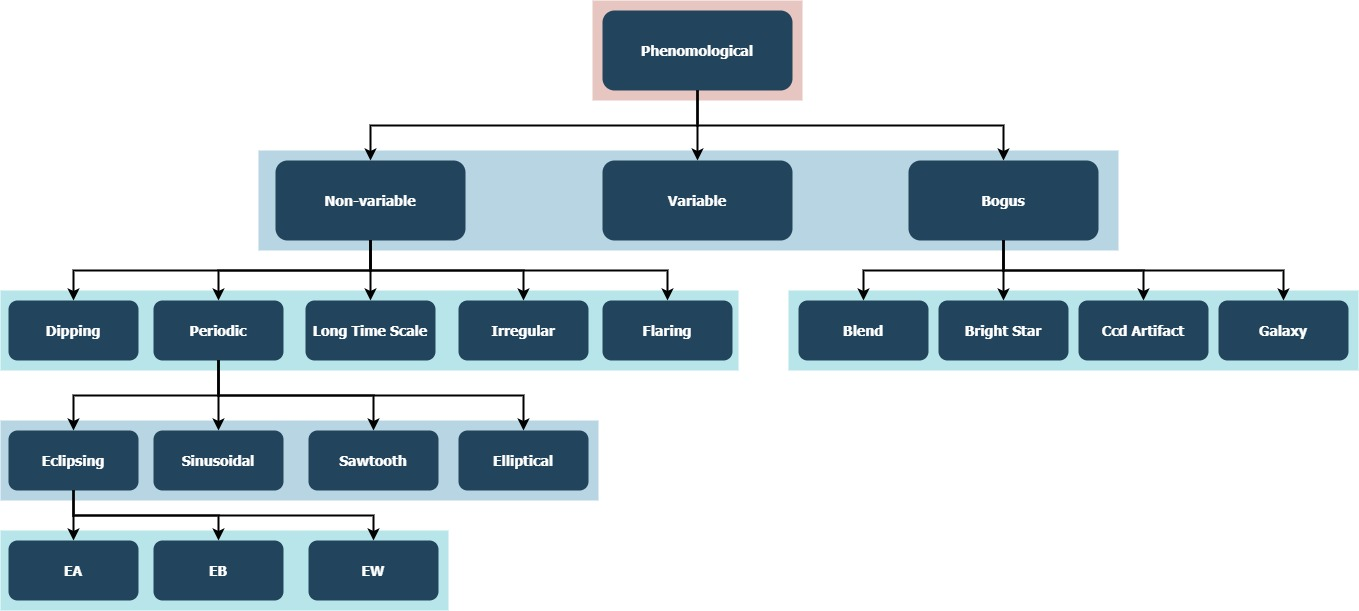

In [3]:
#Hierarchical structure for phenomological variables

Image(filename='diagrams/Phenomological.jpg')

In [68]:
labels_hierarchy = ['variable', 'non-variable', 'bogus']
X_train2_hierarchy, X_test2_hierarchy, y_train2_hierarchy, y_test2_hierarchy = train_test_split(naive_df_feats_scaled.values, 
                                                    df_labels_hierarchy[labels_hierarchy].values, 
                                                                                            test_size=0.2, random_state=8581)

for i in range(y_train2_hierarchy.shape[1]):
    clf = svm.SVC(kernel = 'rbf')
    clf.fit(X_train2_hierarchy, y_train2_hierarchy[:,i])
    pred[labels_hierarchy[i]] = clf.predict(naive_df_feats_scaled.values)
    pred_test = clf.predict(X_test2_hierarchy)
    acc = accuracy_score(y_test2_hierarchy[:,i], pred_test)
    labels_hier.append(labels_hierarchy[i])
    acc_hier.append(acc)
    print(labels_hierarchy[i], ': ', acc)
    
    

labels_hierarchy_bogus = ['blend','bright star', 'ccd artifact', 'galaxy']
indices = np.where(pred['bogus'] == 0)
feats_bogus = naive_df_feats_scaled.iloc[indices]
labels_bogus = df_labels_hierarchy.iloc[indices]
X_train2_hierarchy, X_test2_hierarchy, y_train2_hierarchy, y_test2_hierarchy = train_test_split(feats_bogus.values, 
                                                    labels_bogus[labels_hierarchy_bogus].values, 
                                                                                            test_size=0.2, random_state=8581)

for i in range(y_train2_hierarchy.shape[1]):
    clf = svm.SVC(kernel = 'rbf')
    clf.fit(X_train2_hierarchy, y_train2_hierarchy[:,i])
    pred[labels_hierarchy_bogus[i]] = clf.predict(naive_df_feats_scaled.values)
    pred_test = clf.predict(X_test2_hierarchy)
    acc = accuracy_score(y_test2_hierarchy[:,i], pred_test)
    labels_hier.append(labels_hierarchy_bogus[i])
    acc_hier.append(acc)
    print(labels_hierarchy_bogus[i], ': ', acc)
    
    
    
labels_hierarchy_nonvar = ['dipping', 'periodic', 'long timescale', 'irregular', 'flaring']
indices = np.where(pred['non-variable'] == 0)
feats_nonvar = naive_df_feats_scaled.iloc[indices]
labels_nonvar = df_labels_hierarchy.iloc[indices]
X_train2_hierarchy, X_test2_hierarchy, y_train2_hierarchy, y_test2_hierarchy = train_test_split(feats_nonvar.values, 
                                                    labels_nonvar[labels_hierarchy_nonvar].values, 
                                                                                            test_size=0.2, random_state=8581)

for i in range(y_train2_hierarchy.shape[1]):
    if len(np.unique(y_train2_hierarchy[:,i])) > 1:
        clf = svm.SVC(kernel = 'rbf')
        clf.fit(X_train2_hierarchy, y_train2_hierarchy[:,i])
        pred[labels_hierarchy_nonvar[i]] = clf.predict(naive_df_feats_scaled.values)
        pred_test = clf.predict(X_test2_hierarchy)
    else:
        pred[labels_hierarchy_nonvar[i]] = np.unique(y_train2_hierarchy[:,i])[0]
        pred_test = np.zeros((X_test2_hierarchy.shape[0]))
        pred_test[:] = np.unique(y_train2_hierarchy[:,i])[0]
    acc = accuracy_score(y_test2_hierarchy[:,i], pred_test)
    labels_hier.append(labels_hierarchy_nonvar[i])
    acc_hier.append(acc)
    print(labels_hierarchy_nonvar[i], ': ', acc)
    
    
    
labels_hierarchy_periodic = ['eclipsing', 'sinusoidal', 'sawtooth', 'elliptical']
indices = np.where(pred['periodic'] == 0)
feats_periodic = naive_df_feats_scaled.iloc[indices]
labels_periodic = df_labels_hierarchy.iloc[indices]
X_train2_hierarchy, X_test2_hierarchy, y_train2_hierarchy, y_test2_hierarchy = train_test_split(feats_periodic.values, 
                                                    labels_periodic[labels_hierarchy_periodic].values, 
                                                                                            test_size=0.2, random_state=8581)

for i in range(y_train2_hierarchy.shape[1]):
    if len(np.unique(y_train2_hierarchy[:,i])) > 1:
        clf = svm.SVC(kernel = 'rbf')
        clf.fit(X_train2_hierarchy, y_train2_hierarchy[:,i])
        pred[labels_hierarchy_periodic[i]] = clf.predict(naive_df_feats_scaled.values)
        pred_test = clf.predict(X_test2_hierarchy)
    else:
        pred[labels_hierarchy_periodic[i]] = np.unique(y_train2_hierarchy[:,i])[0]
        pred_test = np.zeros((X_test2_hierarchy.shape[0]))
        pred_test[:] = np.unique(y_train2_hierarchy[:,i])[0]
    acc = accuracy_score(y_test2_hierarchy[:,i], pred_test)
    labels_hier.append(labels_hierarchy_periodic[i])
    acc_hier.append(acc)
    print(labels_hierarchy_periodic[i], ': ', acc)
    
    
    
labels_hierarchy_eclipsing = ['EA', 'EB', 'EW']
indices = np.where(pred['eclipsing'] == 0)
feats_eclipsing = naive_df_feats_scaled.iloc[indices]
labels_eclipsing = df_labels_hierarchy.iloc[indices]
X_train2_hierarchy, X_test2_hierarchy, y_train2_hierarchy, y_test2_hierarchy = train_test_split(feats_eclipsing.values, 
                                                    labels_eclipsing[labels_hierarchy_eclipsing].values, 
                                                                                            test_size=0.2, random_state=8581)

for i in range(y_train2_hierarchy.shape[1]):
    if len(np.unique(y_train2_hierarchy[:,i])) > 1:
        clf = svm.SVC(kernel = 'rbf')
        clf.fit(X_train2_hierarchy, y_train2_hierarchy[:,i])
        pred[labels_hierarchy_eclipsing[i]] = clf.predict(naive_df_feats_scaled.values)
        pred_test = clf.predict(X_test2_hierarchy)
    else:
        pred[labels_hierarchy_eclipsing[i]] = np.unique(y_train2_hierarchy[:,i])[0]
        pred_test = np.zeros((X_test2_hierarchy.shape[0]))
        pred_test[:] = np.unique(y_train2_hierarchy[:,i])[0]
    acc = accuracy_score(y_test2_hierarchy[:,i], pred_test)
    labels_hier.append(labels_hierarchy_eclipsing[i])
    acc_hier.append(acc)
    print(labels_hierarchy_eclipsing[i], ': ', acc)

variable :  0.9701135684399282
non-variable :  0.9703925084678223
bogus :  0.9926280135485156
blend :  0.9971975338297702
bright star :  0.9983985907598687
ccd artifact :  0.9998398590759868
galaxy :  0.9985587316838818
dipping :  0.9991652754590985
periodic :  0.9296263002439964
long timescale :  0.9899190959291126
irregular :  0.9876075510466161
flaring :  0.9965968922563246
eclipsing :  0.9741864616229575
sinusoidal :  0.9986269394480296
sawtooth :  1.0
elliptical :  0.999725387889606
EA :  0.9938234708109185
EB :  0.9929468021518231
EW :  0.9347678820482168


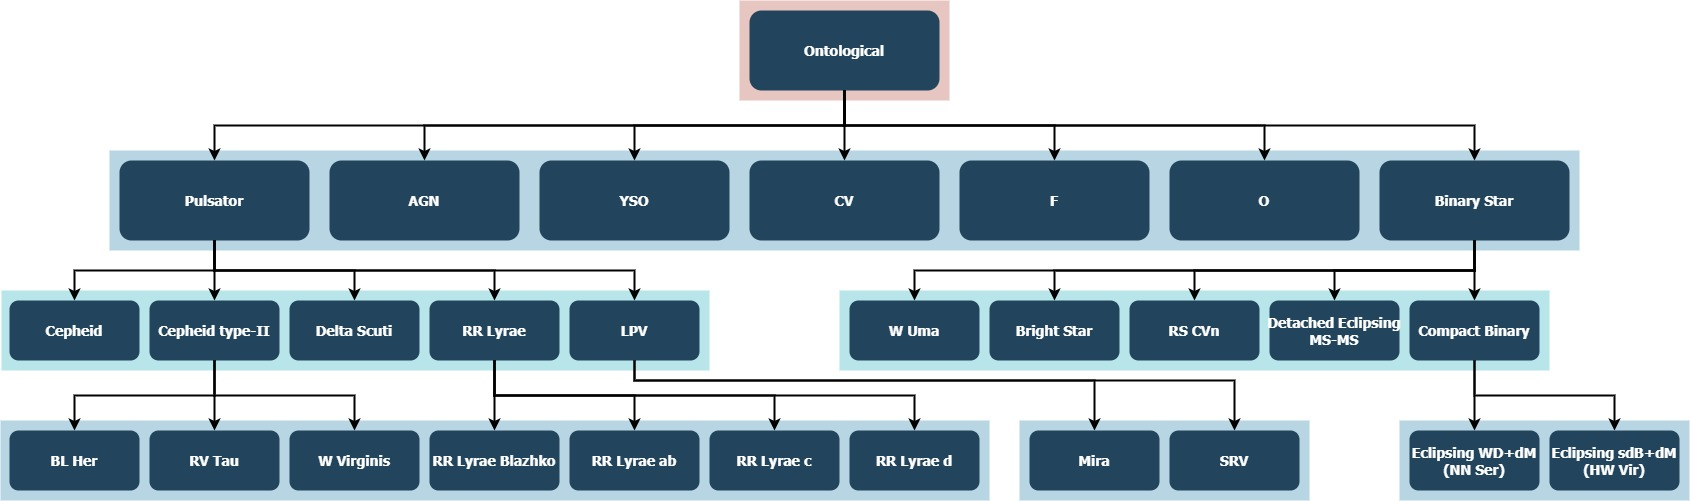

In [7]:
#Hierarchical structure for ontological variables

Image(filename='diagrams/Ontological.jpg')

In [2]:
# YOUR CODE HERE

Below, we see how the accuracy differs for each label from the initial SVM to the hierarchical SVM (both using the RBF kernel).

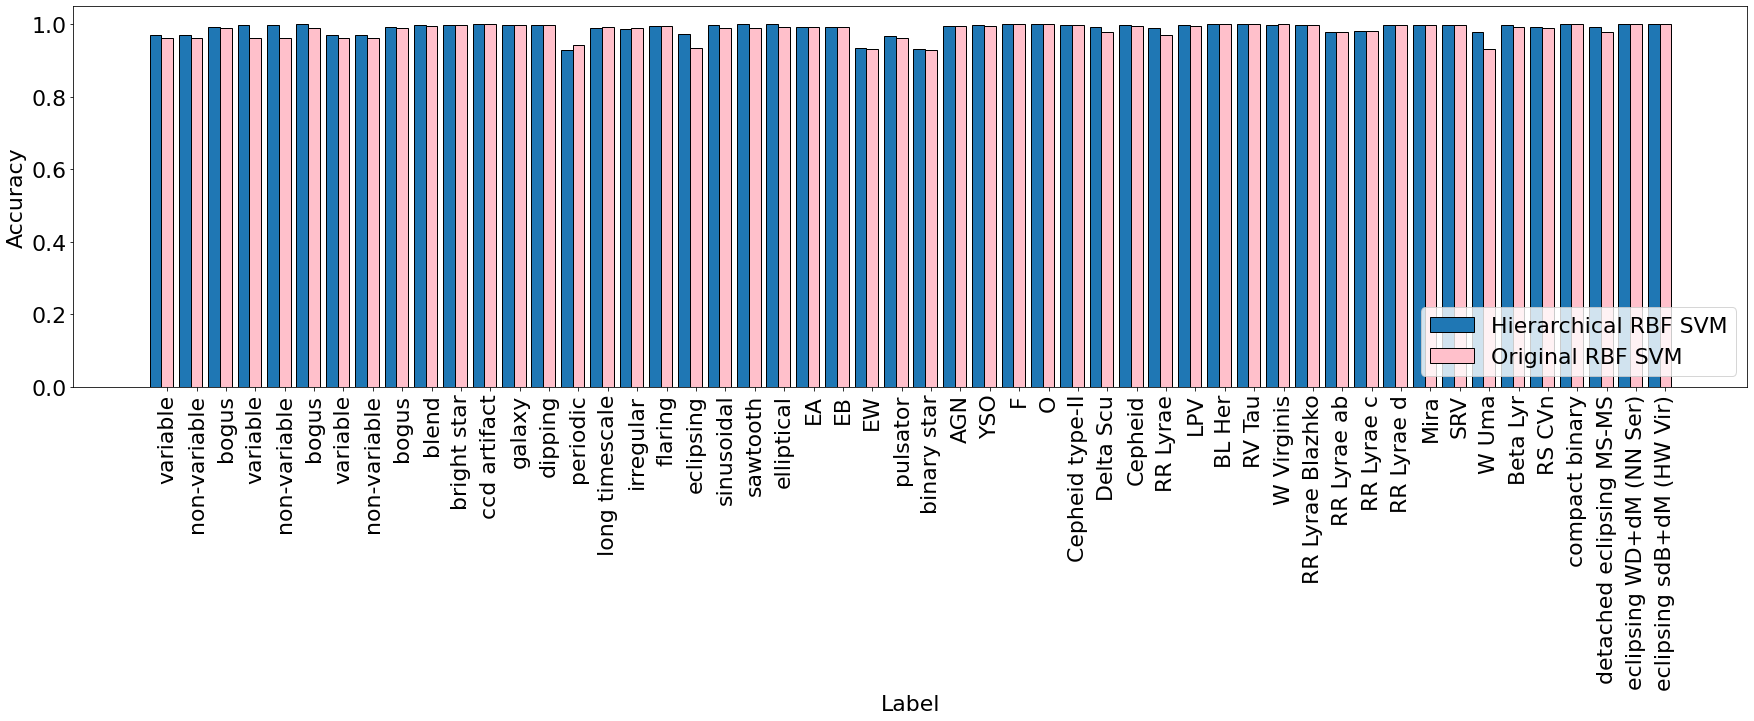

In [71]:
initial_acc = []
for i in labels_hier:
    initial_acc.append(svm_rbf_prediction_accuracies[labels.index(i)])


plt.figure(figsize=(30,7))
plt.rcParams.update({'font.size': 22})

barWidth = 0.4

r1 = np.arange(len(acc_hier))
r2 = [x + barWidth for x in r1]

plt.bar(r1,acc_hier, width=barWidth, edgecolor='black', label='Hierarchical RBF SVM')
plt.bar(r2,initial_acc, color='pink', width=barWidth, edgecolor='black', label='Original RBF SVM')

plt.xlabel('Label')
plt.xticks([r + barWidth for r in range(len(acc_hier))], labels_hier, rotation=90)
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
plt.figure(figsize=(30,7))
plt.rcParams.update({'font.size': 22})

barWidth = 0.8

diff = [a_i - b_i for a_i, b_i in zip(acc_hier, initial_acc)]

r1 = np.arange(len(diff))

plt.bar(r1,diff, width=barWidth, edgecolor='black')

plt.xlabel('Label')
plt.xticks([r for r in range(len(diff))], labels_hier, rotation=90)
plt.ylabel('Difference in Accuracies (Hierarchical-Initial)')

We see above that the hierarchical structure improves the accuracy for nearly all the labels, and a lot of the labels actually improve quite a bit.  Only three of the labels look to have a higher accuracy with the initial SVM instead of the hierarchical SVM, but the decrease in accuracy is not drastic at all for those three labels.

We can also notice that a lot of the labels with more balanced classes, such as "variable" and "non-variable", are the ones that benefit the most from the hierarchical structure, which is what we expect.